In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import utils
import pickle
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

tf.__version__

'2.2.0'

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SIGMAS = utils.get_sigma_levels().numpy()

In [4]:
model = load_model(inlier_name="cifar10", checkpoint=8, split="95,5")

(1, 32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  302848      conv2d[0][0]                     
                                                                 idx_sigmas[0][

In [5]:
datasets = ["LSUN", "LSUN_resize", "Imagenet", "Imagenet_resize", "iSUN"] 
img_height, img_width = 32, 32

In [6]:
@tf.function
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [7]:
@tf.function
def process_path(file_path):
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img /= 255 
    return img

In [8]:
test_ds = []

for ds_name in datasets:
    data_dir = 'data/' + ds_name
    list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(512)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    test_ds.append(ds)

In [9]:
for imgs in test_ds[-1].take(1):
    print(np.histogram(imgs[0]))

(array([160, 348, 618, 679, 549, 228, 162,  92,  58, 178]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))


LSUN


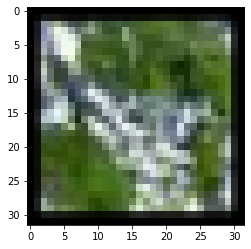

LSUN_resize


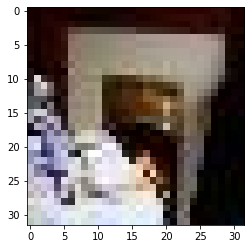

Imagenet


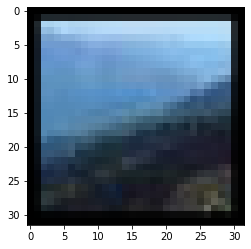

Imagenet_resize


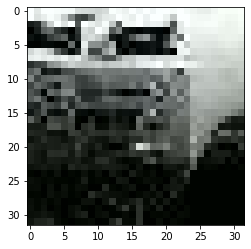

iSUN


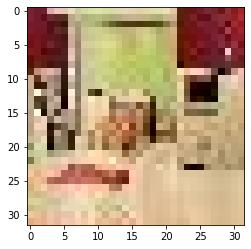

In [10]:
for name, ds in zip(datasets, test_ds):
    image = next(iter(ds.take(1)))
    print(name)
    plt.imshow(image[0].numpy())
    plt.show()

In [11]:
%%time
ood_dists = []
progress_bar = tqdm(zip(datasets, test_ds))

for name, outlier in progress_bar:
    progress_bar.set_description(name)
    ood_dists.append(compute_scores(model, outlier))

LSUN: : 0it [00:00, ?it/s]
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.47s/it]
LSUN_resize: : 1it [03:04, 184.68s/it]
Sigma: 0.0100: 100%|██████████| 10/10 [03:01<00:00, 18.16s/it]
Imagenet: : 2it [06:06, 183.83s/it]   
Sigma: 0.0100: 100%|██████████| 10/10 [03:01<00:00, 18.19s/it]
Imagenet_resize: : 3it [09:08, 183.32s/it]
Sigma: 0.0100: 100%|██████████| 10/10 [03:01<00:00, 18.19s/it]
iSUN: : 4it [12:10, 182.96s/it]           
Sigma: 0.0100: 100%|██████████| 10/10 [02:43<00:00, 16.38s/it]
iSUN: : 5it [14:54, 178.97s/it]

CPU times: user 7min 37s, sys: 4min 15s, total: 11min 53s
Wall time: 14min 54s


In [12]:
%%time
scores = {}
for name, ds in zip(datasets, ood_dists):
#     scores[name] = weighted_norm(ds)
    scores[name] = weighted_norm(ds)

CPU times: user 1.3 s, sys: 274 ms, total: 1.57 s
Wall time: 2.26 s


### Artificial Datasets

In [13]:
TEST_BATCH = 500

x = tf.random.normal(shape=(TEST_BATCH*20, 32,32,3) , mean=0.5, stddev=1.0)
x = tf.clip_by_value(x, 0.0, 1.0)
gaussian_test_batches = tf.split(x, 20)

x = tf.random.uniform(shape=(TEST_BATCH*20, 32,32,3), minval=0.0, maxval=1.0)
uniform_test_batches = tf.split(x, 20)

In [14]:
artificial_ood = (gaussian_test_batches, uniform_test_batches)

In [15]:
%%time
for name, outlier in zip(["gaussian", "uniform"], artificial_ood):
    score = compute_scores(model, outlier)
#     scores[name] = weighted_norm(score)
    scores[name] = full_norm(score)

Sigma: 0.0100: 100%|██████████| 10/10 [03:03<00:00, 18.34s/it]

CPU times: user 2min 14s, sys: 1min 12s, total: 3min 27s
Wall time: 6min 9s


In [17]:
scores.keys()

dict_keys(['LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform'])

### CIFAR

In [17]:
with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar10_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    cifar10_test = cifar10_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar10_test = cifar10_test.batch(512)

In [18]:
%%time
cifar10_scores = compute_scores(model, cifar10_test)
# cifar10_scores = weighted_norm(cifar10_scores)
cifar10_scores = full_norm(cifar10_scores)

Sigma: 0.0100: 100%|██████████| 10/10 [03:01<00:00, 18.18s/it]

CPU times: user 1min 19s, sys: 46.9 s, total: 2min 5s
Wall time: 3min 1s


In [19]:
scores["cifar"] = cifar10_scores

In [26]:
scores.keys()

dict_keys(['LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform', 'svhn'])

In [25]:
[x.shape for x in scores.values()]

[TensorShape([10000, 10]),
 TensorShape([10000, 10]),
 TensorShape([10000, 10]),
 TensorShape([10000, 10]),
 TensorShape([8925, 10]),
 TensorShape([10000, 10]),
 TensorShape([10000, 10]),
 TensorShape([26000, 10])]

In [22]:
import pickle

with open("cifar10/ood_scores_full_norm.p", "wb") as f:
    pickle.dump(scores, f)

### SVHN

In [21]:
with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    svhn_test = svhn_test.take(26000)
    svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    svhn_test = svhn_test.batch(260)

In [22]:
%%time
svhn_scores = compute_scores(model, svhn_test)
svhn_scores = weighted_norm(svhn_scores)
# svhn_scores = full_norm(svhn_scores)

Sigma: 0.0100: 100%|██████████| 10/10 [07:56<00:00, 47.66s/it]


CPU times: user 4min 22s, sys: 1min 14s, total: 5min 37s
Wall time: 7min 57s


In [23]:
scores["svhn"] = svhn_scores
svhn_scores.shape

TensorShape([26000, 10])

In [24]:
with open("cifar10/ood_scores_95_5.p", "wb") as f:
    pickle.dump(scores, f)

In [22]:
# with open("svhn/scores_full_norm_test.p", "wb") as f:
#     pickle.dump(svhn_scores, f)

> ### 5% Held out Train

In [ ]:
with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['train[-5%:]']["image"])
    svhn_test = svhn_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    svhn_test = svhn_test.batch(260)

### CIFAR 10.1

In [23]:
with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar101_test = tf.data.Dataset.from_tensor_slices(data_generators['test']["image"])
    cifar101_test = cifar101_test.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    cifar101_test = cifar101_test.batch(512)

(array([415, 783, 297, 227, 194, 150,  95, 354, 389, 168]), array([0.        , 0.08627451, 0.17254902, 0.25882354, 0.34509805,
       0.43137255, 0.5176471 , 0.6039216 , 0.6901961 , 0.7764706 ,
       0.8627451 ], dtype=float32))


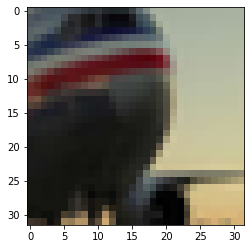

In [24]:
for imgs in cifar101_test.take(1):
    print(np.histogram(imgs[0]))
    plt.imshow(imgs[0].numpy())
    plt.show()

In [25]:
%%time
cifar101_scores = compute_scores(model, cifar101_test)

cifar101_scores = weighted_norm(cifar101_scores)

Sigma: 0.0100: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


CPU times: user 15.6 s, sys: 11 s, total: 26.7 s
Wall time: 38.1 s


In [26]:
with open("cifar101_scores_ckpt-20.p", "wb") as f:
    pickle.dump(cifar101_scores, f)